In [77]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nibinv23/iam-handwriting-word-database")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'iam-handwriting-word-database' dataset.
Path to dataset files: /kaggle/input/iam-handwriting-word-database


In [78]:
import os
path = "/root/.cache/kagglehub/datasets/nibinv23/iam-handwriting-word-database/versions/2"
path = f"{path}/iam_words/"
print(os.listdir(path))

['words.txt', 'words']


In [79]:
img_path = []
word = []
words_path = os.path.join(path , "words.txt")
with open (words_path,"r") as f:
  for line in f:
    if line.startswith("#"):
      continue
    parts = line.strip().split()
    if len(parts) < 8:
            continue
    if parts[1] != "ok":
      continue
    image_id = parts[0]
    text = " ".join(parts[8:])
    subdir1 = image_id.split("-")[0]
    subdir2 = "-".join(image_id.split("-")[:2])
    image_path = os.path.join(
            path,
            "words",
            subdir1,
            subdir2,
            image_id + ".png"
        )

    img_path.append(image_path)
    word.append(text)

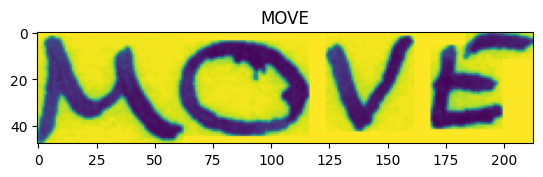

In [80]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
plt.title(word[1])
plt.imshow(imread(img_path[1]))
plt.show()

In [81]:
from torchvision import transforms
Transform = transforms.Compose([
    transforms.Resize((224 , 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5],
        std=[0.5]
    )
])


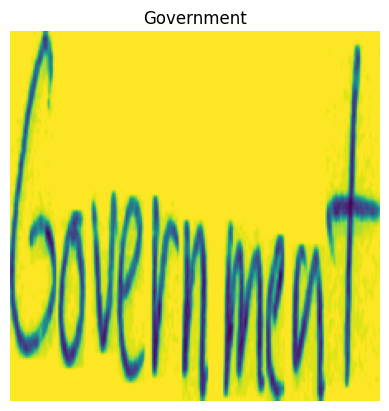

In [82]:
from PIL import Image
import matplotlib.pyplot as plt
index = 9000
image = Image.open(img_path[index]).convert("L")
tr_image = Transform(image)
plt.title(word[index])
plt.imshow(tr_image.permute(1, 2, 0))
# permute just change the dimension so that matplotlib can take it
plt.axis("off")
plt.show()


In [83]:
size = 10000
img_path = img_path[:size]
word = word[:size]

In [84]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(img_path , word ,test_size=0.2 , random_state = False)

In [85]:
all_text = "".join(word)
chars = sorted(list(set(all_text)))

char_to_idx = {c: i+1 for i, c in enumerate(chars)}
idx_to_char = {i: c for c, i in char_to_idx.items()}
num_classes = len(char_to_idx) + 1
print(f"Num characters (with blank): {num_classes}")

Num characters (with blank): 76


In [86]:
from collections import Counter

counts = Counter(y_train)
print(counts)


Counter({'the': 450, '.': 325, ',': 267, 'to': 232, 'of': 221, 'in': 153, 'a': 128, 'and': 126, '"': 121, 'Mr.': 106, 'that': 88, 'is': 87, 'on': 70, 'for': 64, 'was': 60, 'with': 55, 'The': 52, 'his': 51, '-': 47, 'at': 46, 'be': 44, 'by': 43, 'it': 43, 'he': 43, 'had': 40, 'from': 39, 'not': 39, 'have': 37, 'Government': 37, 'He': 35, 'Labour': 34, 'Sir': 34, 'will': 33, 'talks': 32, 'an': 32, 'has': 30, 'would': 29, 'which': 29, 'are': 27, 'as': 26, 'Minister': 26, 'their': 23, 'been': 23, 'said': 22, 'should': 22, 'It': 21, 'President': 20, 'today': 20, 'conference': 20, 'no': 19, 'they': 19, 'Macmillan': 18, 'were': 17, 'last': 16, 'House': 16, 'this': 16, ':': 16, 'but': 16, 'yesterday': 15, 'Northern': 15, 'being': 14, 'West': 14, 'or': 14, 'Kennedy': 14, 'two': 14, 'Britain': 13, 'Federal': 13, 'them': 13, 'people': 13, 'now': 13, 'who': 13, 'there': 13, 'British': 13, 'all': 12, 'Macleod': 12, 'Roy': 12, 'Powell': 12, 'out': 12, 'policy': 12, 'service': 12, 'Party': 12, 'more'

In [94]:
import torch
from torch.utils.data import Dataset , DataLoader
from PIL import Image, UnidentifiedImageError
class handwriting_dataset(Dataset):
  def __init__(self , img_path , words , transforms):
    self.img_path = img_path
    self.words = words
    self.transforms = transforms
  def __len__(self):
    return len(self.words)
  def __getitem__(self,idx):
     try:
        image = Image.open(self.img_path[idx]).convert("L")
     except (UnidentifiedImageError, OSError):
        return self.__getitem__((idx + 1) % len(self.words))
     if self.transforms:
        image = self.transforms(image)
     word = self.words[idx]
     target = torch.tensor([char_to_idx[c] for c in word], dtype=torch.long)
     return image, target


In [95]:
import torch.nn.functional as F
def collate_fn(batch):
    imgs, targets = zip(*batch)

    imgs = torch.stack(imgs)

    targets_flat = torch.cat(targets)
    target_lengths = torch.tensor([len(t) for t in targets], dtype=torch.long)

    # CNN width after pooling: 224 → 112 → 56
    input_lengths = torch.full(
        size=(len(imgs),),
        fill_value=56,
        dtype=torch.long
    )

    return imgs, targets_flat, input_lengths, target_lengths

In [96]:
Train_Dataset = handwriting_dataset(X_train , y_train , Transform)
Train_dataloader = DataLoader(Train_Dataset , batch_size=8 , shuffle = True , collate_fn=collate_fn)

In [97]:
import torch.nn as nn

class OCRModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 224 → 112

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)    # 112 → 56
        )

        # CNN output: [B, 128, 56, 56]
        self.rnn = nn.LSTM(
            input_size=128 * 56,
            hidden_size=256,
            num_layers=2,
            bidirectional=True,
            batch_first=True
        )

        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.cnn(x)              # [B, 128, 56, 56]
        x = x.permute(0, 3, 1, 2)    # [B, W=56, C=128, H=56]
        x = x.flatten(2)             # [B, 56, 128*56]
        x, _ = self.rnn(x)           # [B, 56, 512]
        x = self.fc(x)               # [B, 56, num_classes]
        x = x.permute(1, 0, 2)       # [T, B, C]
        return x


In [98]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [99]:
import torch.optim as optim
model = OCRModel(num_classes)
model = model.to(device)
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [100]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, targets_flat, input_lengths, target_lengths in Train_dataloader:
        images = images.to(device)
        targets_flat = targets_flat.to(device)
        input_lengths = input_lengths.to(device)
        target_lengths = target_lengths.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        log_probs = F.log_softmax(outputs, dim=2)

        loss_value = criterion(log_probs, targets_flat, input_lengths, target_lengths)
        loss_value.backward()
        optimizer.step()

        running_loss += loss_value.item()

    avg_loss = running_loss / len(Train_dataloader)
    print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}")


Epoch: 1, Loss: 4.3256
Epoch: 2, Loss: 3.1647
Epoch: 3, Loss: 2.8307
Epoch: 4, Loss: 2.5443
Epoch: 5, Loss: 2.3214
Epoch: 6, Loss: 2.1380
Epoch: 7, Loss: 1.9823
Epoch: 8, Loss: 1.8397
Epoch: 9, Loss: 1.7173
Epoch: 10, Loss: 1.6037
Epoch: 11, Loss: 1.4800
Epoch: 12, Loss: 1.3783
Epoch: 13, Loss: 1.2692
Epoch: 14, Loss: 1.1695
Epoch: 15, Loss: 1.0651
Epoch: 16, Loss: 0.9648
Epoch: 17, Loss: 0.8671
Epoch: 18, Loss: 0.7822
Epoch: 19, Loss: 0.6943
Epoch: 20, Loss: 0.6187
Epoch: 21, Loss: 0.5303
Epoch: 22, Loss: 0.4806
Epoch: 23, Loss: 0.4002
Epoch: 24, Loss: 0.3435
Epoch: 25, Loss: 0.2997
Epoch: 26, Loss: 0.2591
Epoch: 27, Loss: 0.2216
Epoch: 28, Loss: 0.2047
Epoch: 29, Loss: 0.1648
Epoch: 30, Loss: 0.1212
Epoch: 31, Loss: 0.1253
Epoch: 32, Loss: 0.1584
Epoch: 33, Loss: 0.0939
Epoch: 34, Loss: 0.0650
Epoch: 35, Loss: 0.0656
Epoch: 36, Loss: 0.1282
Epoch: 37, Loss: 0.0855
Epoch: 38, Loss: 0.0693
Epoch: 39, Loss: 0.0369
Epoch: 40, Loss: 0.0320
Epoch: 41, Loss: 0.1126
Epoch: 42, Loss: 0.0674
E

In [101]:
 def ctc_decode(log_probs, idx_to_char):
    preds = log_probs.argmax(2).permute(1, 0)  # [B, T]
    decoded = []
    for pred in preds:
        pred = pred.cpu().numpy()
        chars = []
        previous = None
        for p in pred:
            if p != previous and p != 0:
                chars.append(idx_to_char[p])
            previous = p
        decoded.append("".join(chars))
    return decoded


In [105]:
model.eval()
correct_words = 0
total_words = 0

testing_data = handwriting_dataset(X_test, y_test, Transform)
test_dataloader = DataLoader(
    testing_data,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn
)

with torch.no_grad():
    for inputs, targets_flat, input_lengths, target_lengths in test_dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        log_probs = F.log_softmax(outputs, dim=2)
        preds = ctc_decode(log_probs, idx_to_char)

        start = 0
        true_words = []
        for length in target_lengths:
            chars = [idx_to_char[i.item()] for i in targets_flat[start:start+length]]
            true_words.append("".join(chars))
            start += length

        for t, p in zip(true_words, preds):
            if t == p:
                correct_words += 1

        total_words += len(true_words)

accuracy = 100 * correct_words / total_words
print(f"Test Accuracy (word-level): {accuracy:.2f}%")


Test Accuracy (word-level): 35.35%


In [106]:
model.eval()
correct_words = 0
total_words = 0

testing_data = handwriting_dataset(X_train, y_train, Transform)
test_dataloader = DataLoader(
    testing_data,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn
)

with torch.no_grad():
    for inputs, targets_flat, input_lengths, target_lengths in test_dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        log_probs = F.log_softmax(outputs, dim=2)
        preds = ctc_decode(log_probs, idx_to_char)

        start = 0
        true_words = []
        for length in target_lengths:
            chars = [idx_to_char[i.item()] for i in targets_flat[start:start+length]]
            true_words.append("".join(chars))
            start += length

        for t, p in zip(true_words, preds):
            if t == p:
                correct_words += 1

        total_words += len(true_words)

accuracy = 100 * correct_words / total_words
print(f"Train Accuracy (word-level): {accuracy:.2f}%")


Train Accuracy (word-level): 95.41%
